In [85]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('B://workspace/tensorflow/')

# 训练 Conv-LSTM 模型。
# 该模型通过同一个月的前 14 天的 SST 数据预测未来 1 天的 SST 数据。

# 导入数据集
from torch.utils.data import DataLoader

from src.dataset.ERA5 import ERA5SSTDataset

# 定义参数
offset = 2000
width = 15
step = 2
lon = [40, 60]
lat=[200, 220]

# 创建全新的数据集
train_data_set = ERA5SSTDataset(width, step, offset, lon, lat)
val_data_set = ERA5SSTDataset(width, step * 2, offset, lon, lat)
test_data_set = ERA5SSTDataset(width, step, offset + 200, lon, lat)

train_dataloader = DataLoader(train_data_set, batch_size=20, shuffle=False)
val_dataloader = DataLoader(val_data_set, batch_size=20, shuffle=False)
test_dataloader = DataLoader(test_data_set, batch_size=20, shuffle=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
from lightning import Trainer

from src.models.LSTM import ConvLSTM
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

model = ConvLSTM(1, 20, kernel_size=(5,5), num_layers=20)
el_stop = EarlyStopping(monitor='loss', patience=5, min_delta=0.1)
trainer = Trainer(max_epochs=50, limit_train_batches=20, enable_checkpointing=False, callbacks=[el_stop])

trainer.fit(model, train_dataloaders=train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
D:\tensorflow\.venv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | cell_list | ModuleList  | 1.6 M  | train
1 | fc        | Sequential  | 3.2 M  | train
2 | nor       | BatchNorm2d | 40     | train
--------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.056    Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode
D:\tensorflow\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

Epoch 10: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s, v_num=107]


In [87]:
# 预测
from src.utils.plot import plot_sst_distribution_compare # 导入绘图函数，绘制SST分布的比较图
from src.models.model import ssim # 导入自定义的SSIM损失函数，模型训练时计算损失

from keras.src.saving import load_model  # 从Keras中导入加载模型的函数

# saved_model = load_model(MODEL_SAVE_PATH + '/Conv2DLSTMNetwork.keras', custom_objects={ 'log_cosh':losses.log_cosh, 'Conv2DLSTMNetwork': Conv2DLSTMNetwork})

x_test, y_test = next(iter(test_dataloader))

start_time, end_time = test_data_set.getTime(test_data_set.current)
print(f"Start time: {start_time}, End time: {end_time}")

y_pred = model(x_test) # 使用模型进行预测

print(y_pred.shape)  # 打印第15个样本的预测结果的形状
print(y_test.shape)

Start time: 2005-11-10, End time: 2005-11-25
torch.Size([20, 1, 20, 20])
torch.Size([20, 1, 20, 20])


RMSE: 0.3368597626686096


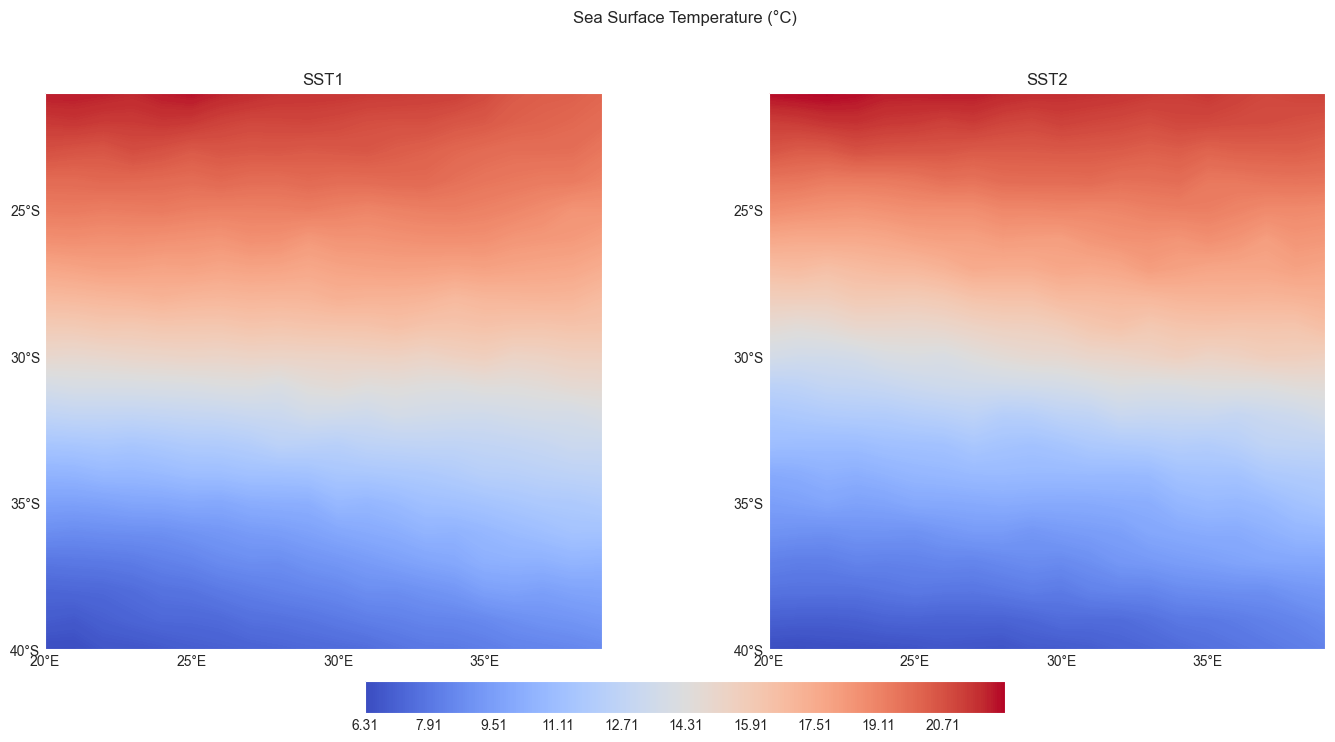

RMSE: 0.8880548477172852


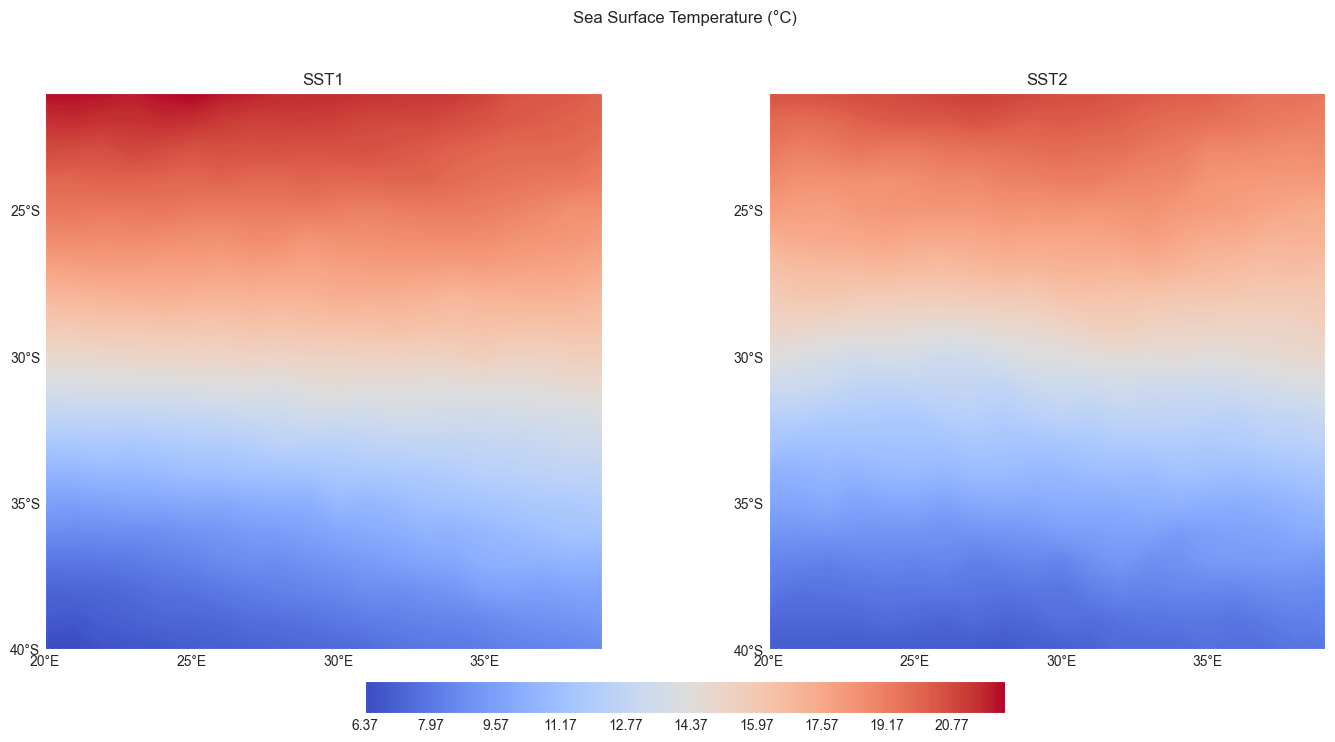

RMSE: 11.089113235473633


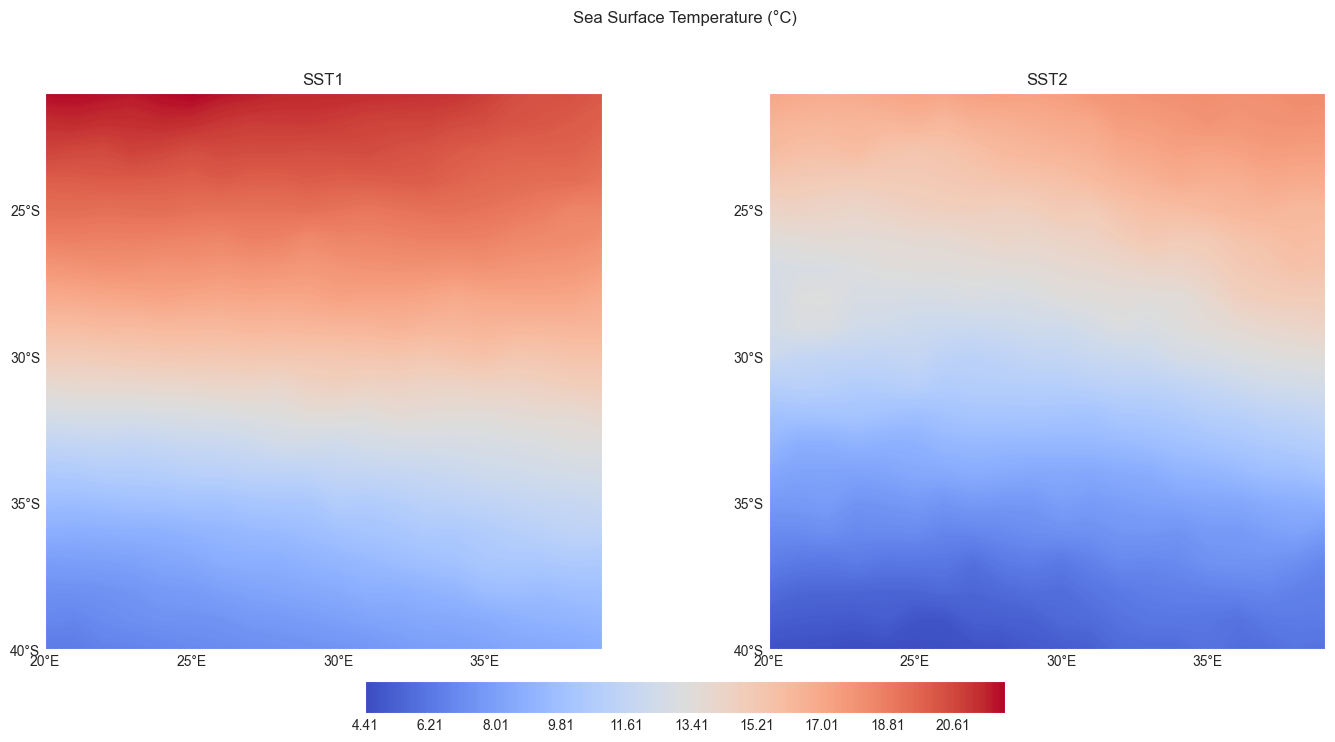

RMSE: 14.216110229492188


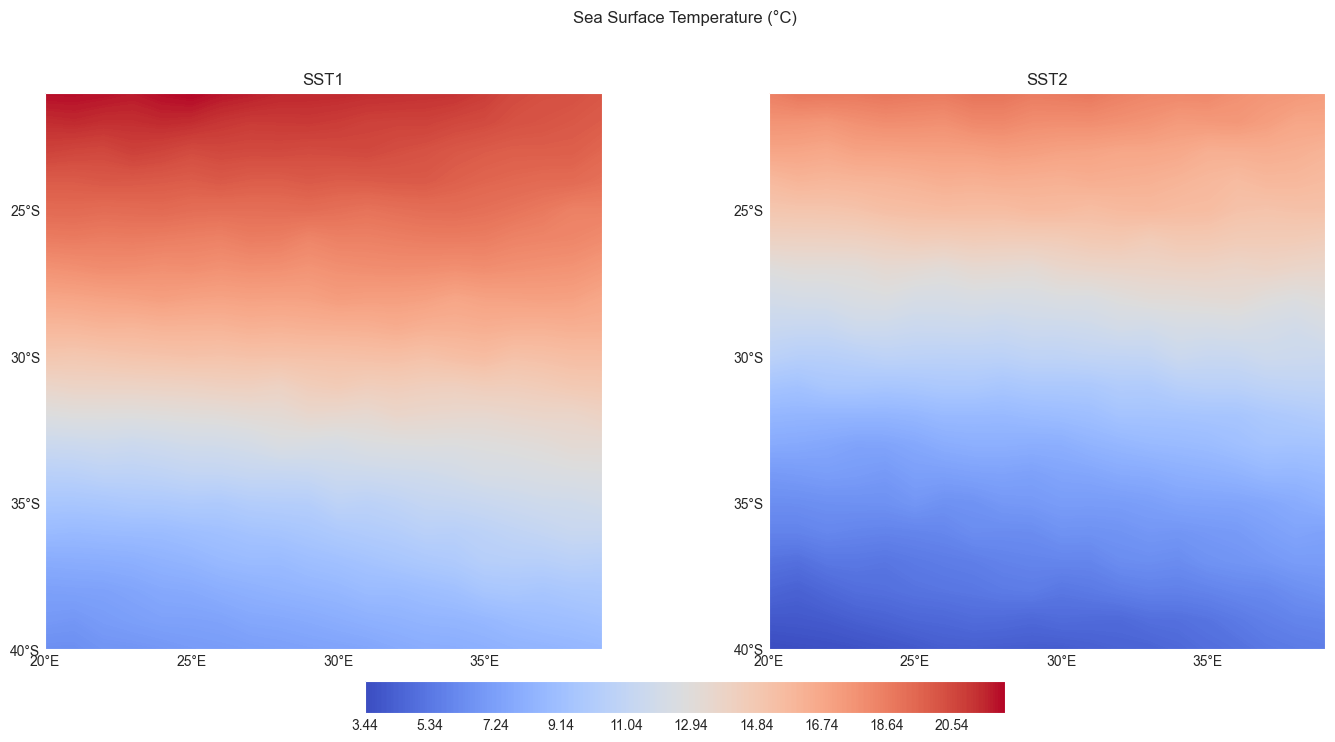

RMSE: 7.66888427734375


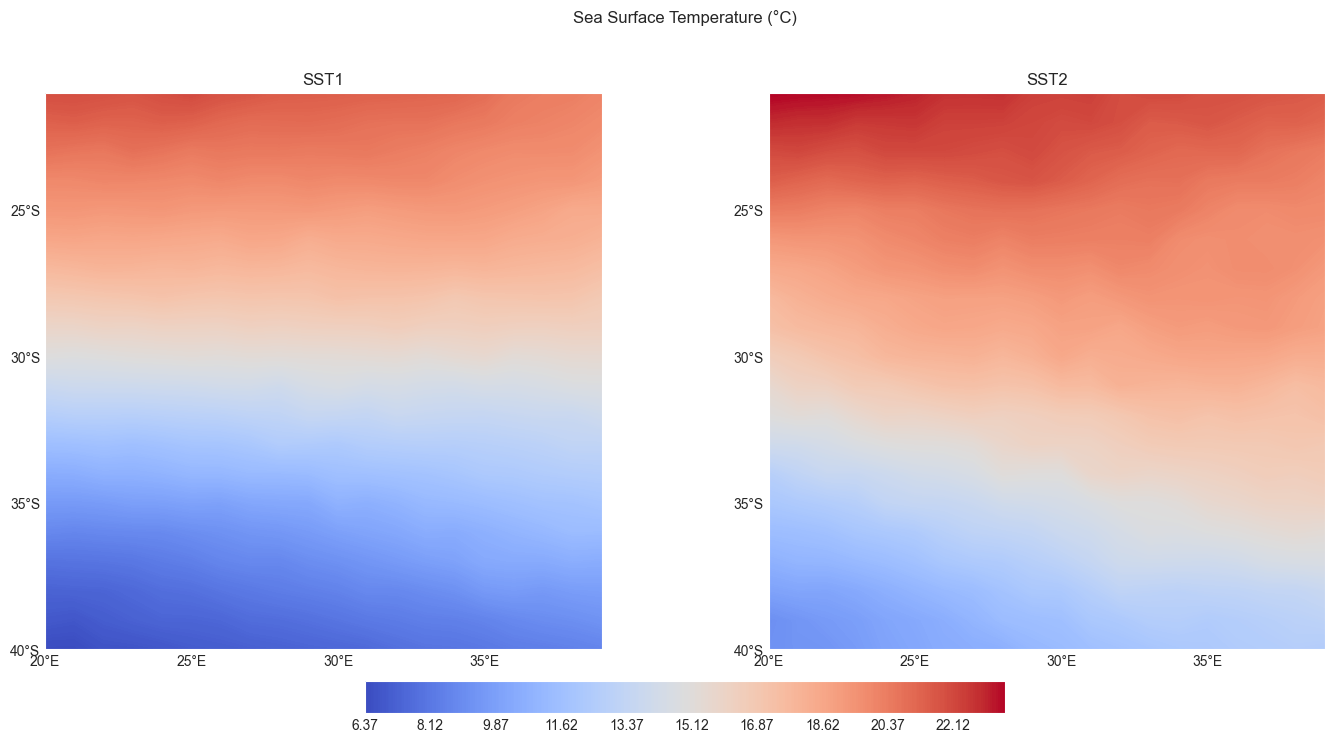

RMSE: 1.7992398738861084


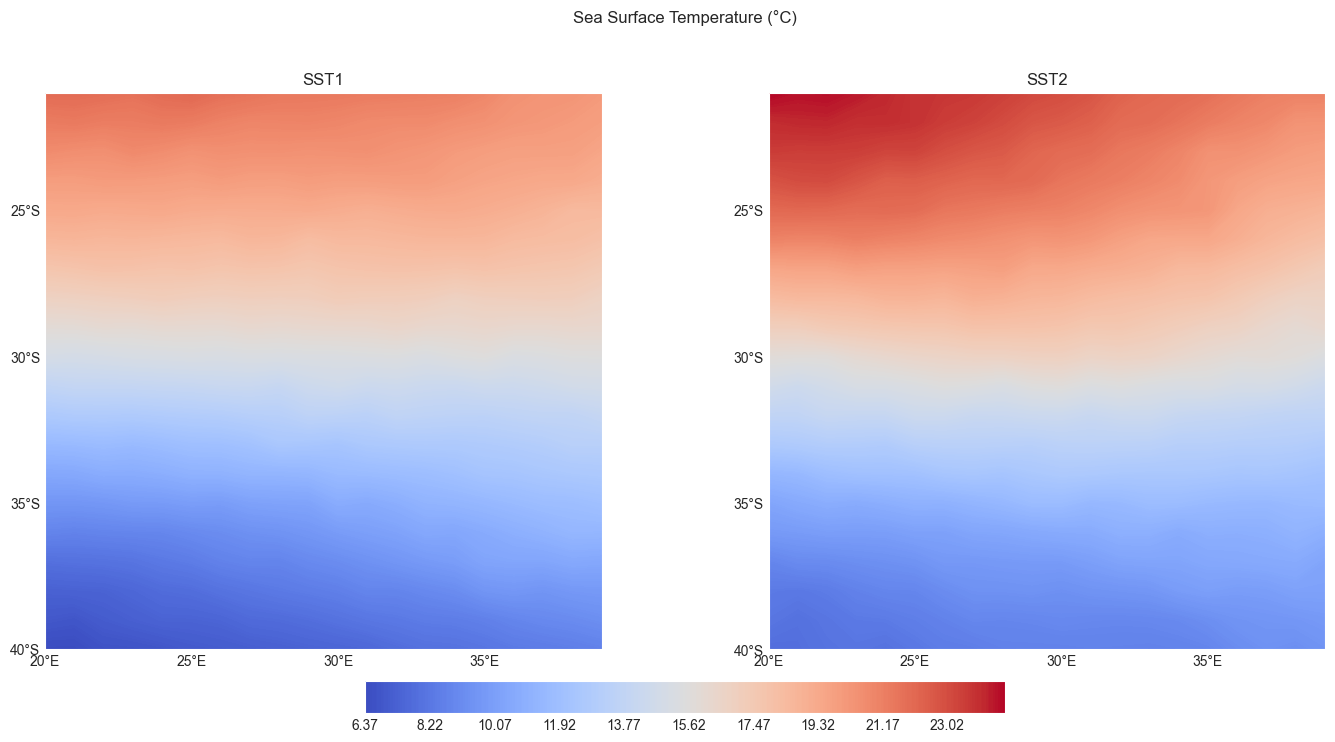

RMSE: 16.91690444946289


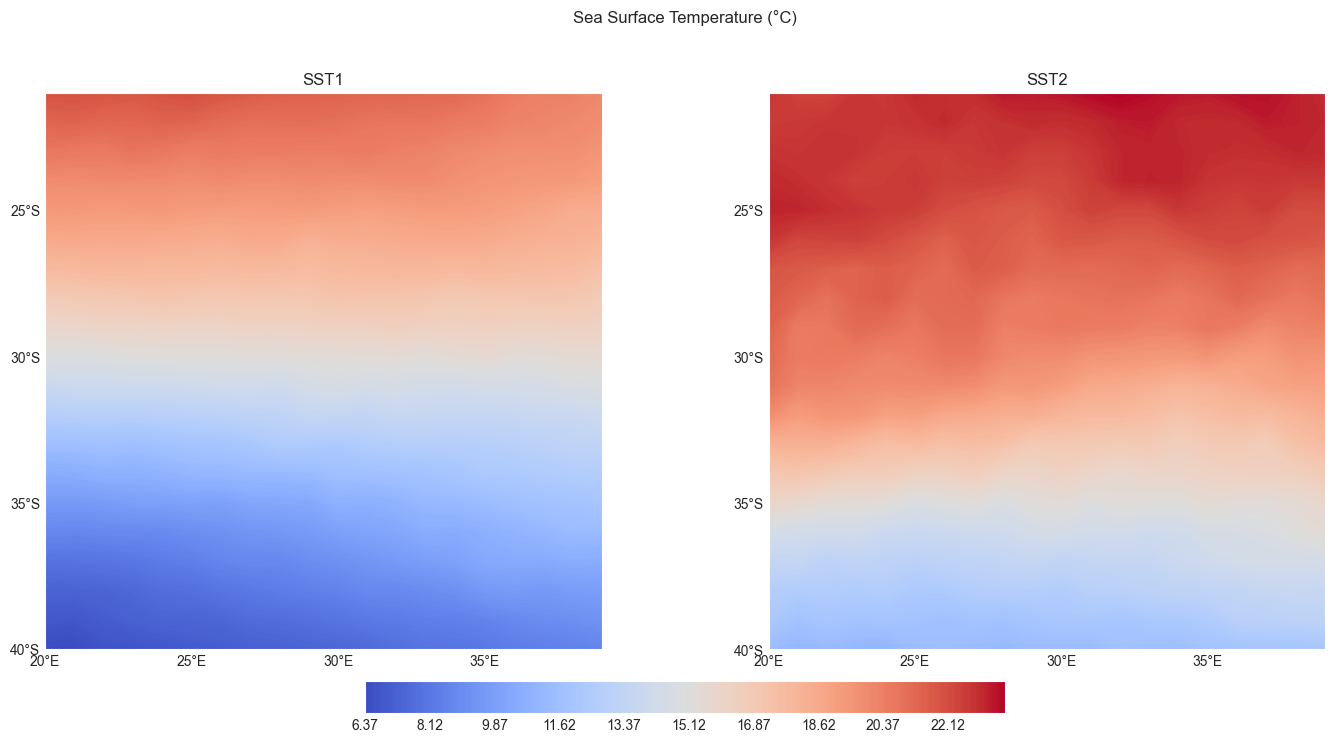

RMSE: 17.71786117553711


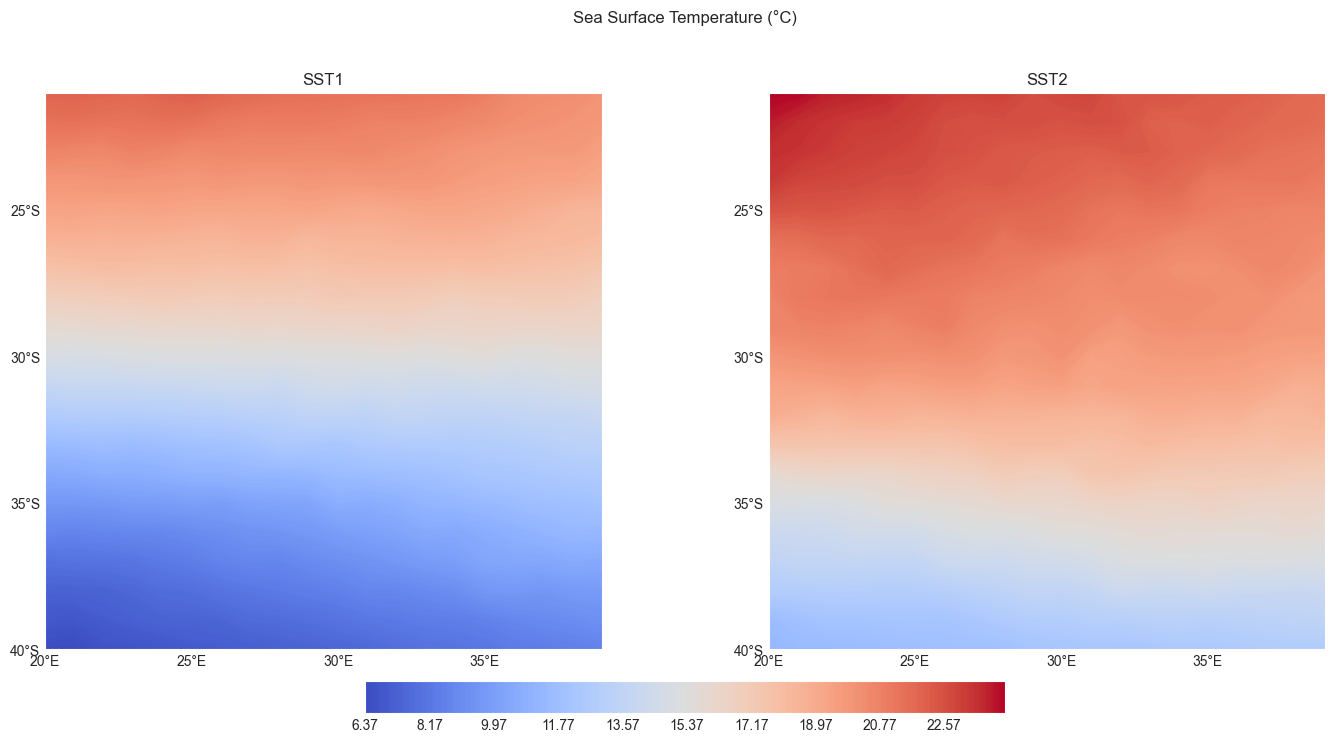

RMSE: 13.73108196258545


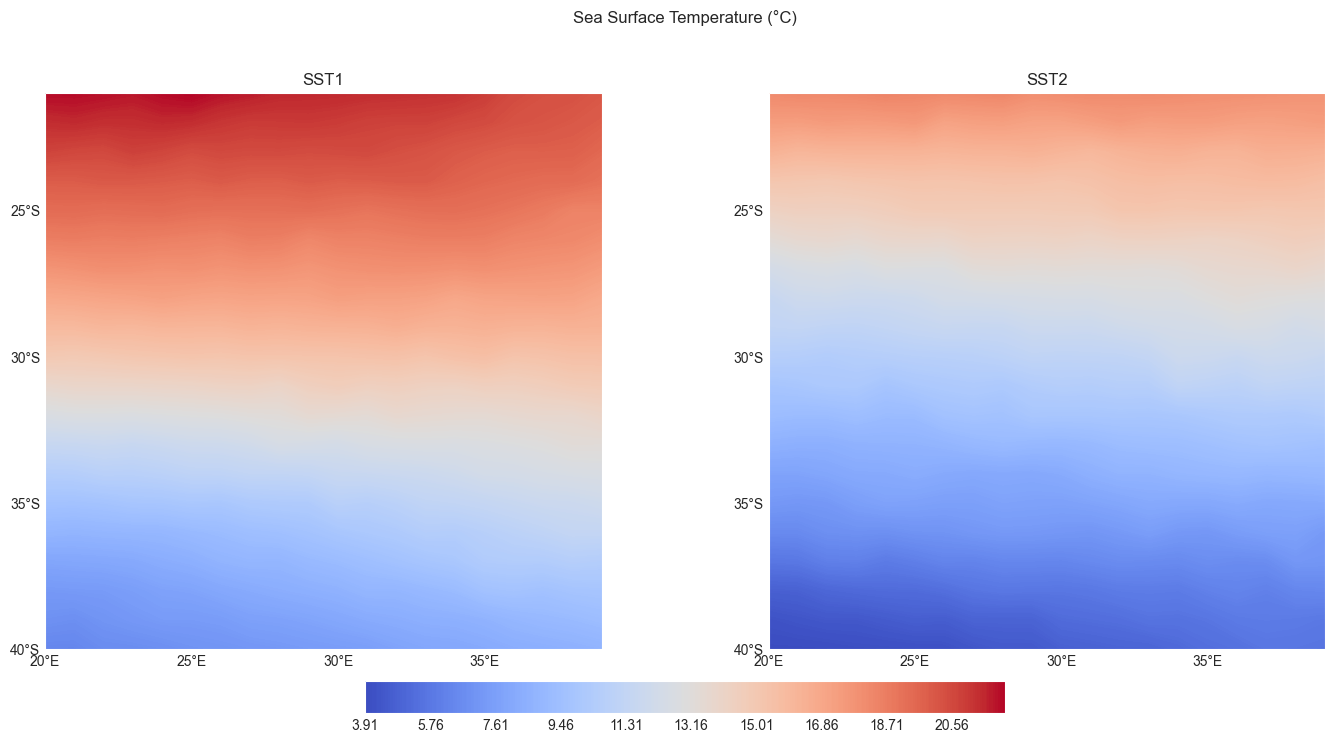

RMSE: 14.320425033569336


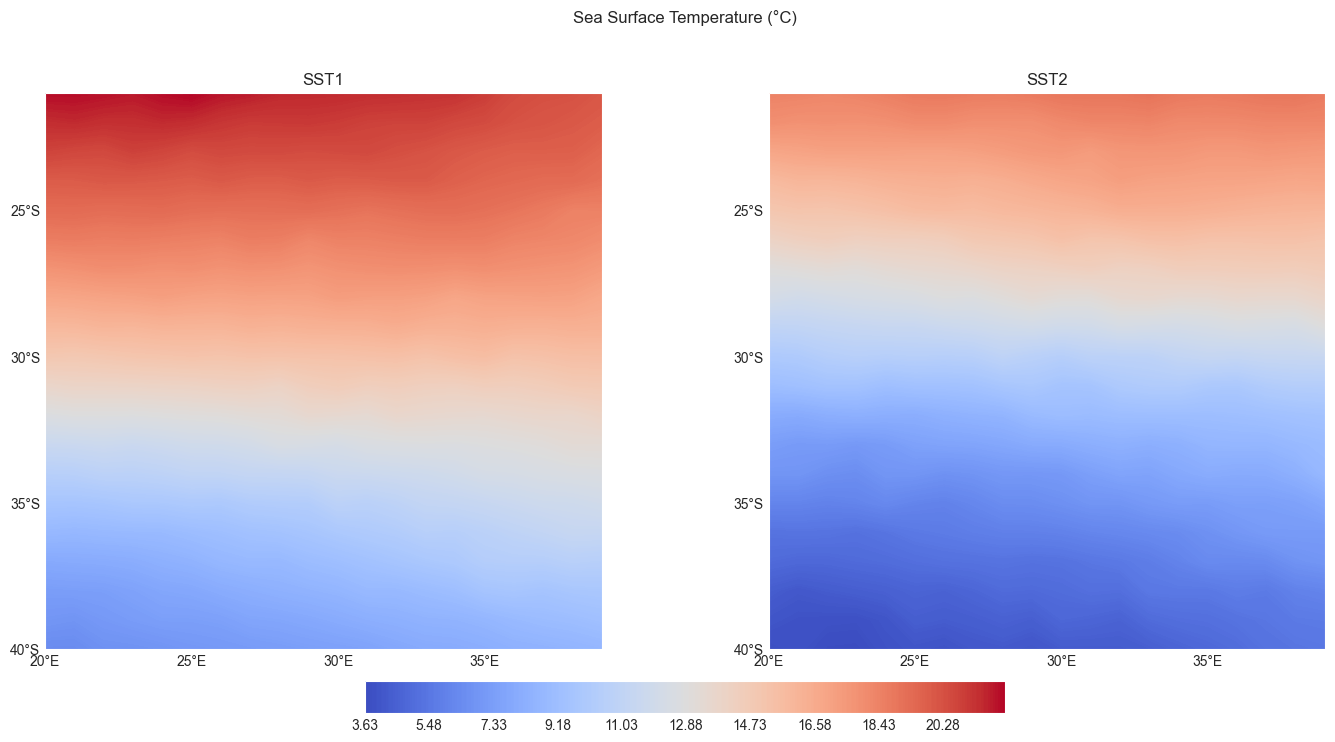

RMSE: 9.57162094116211


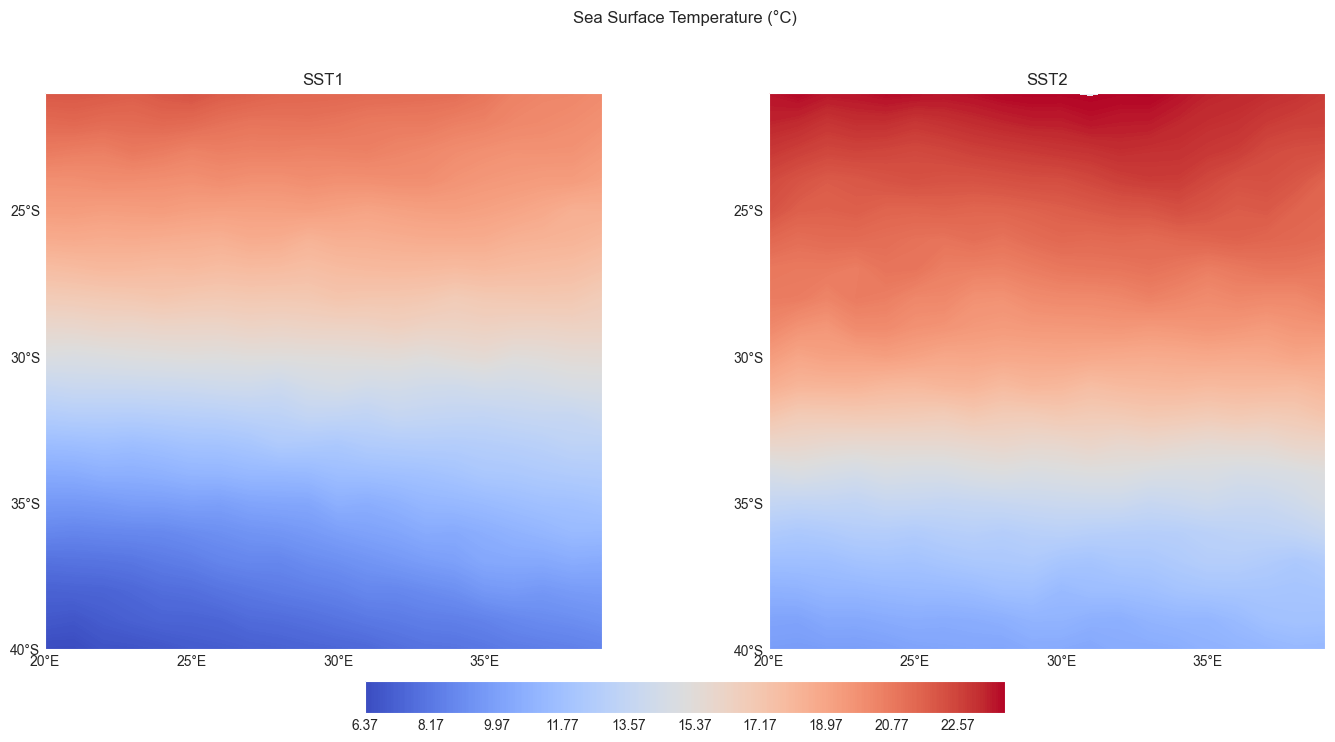

RMSE: 3.016780138015747


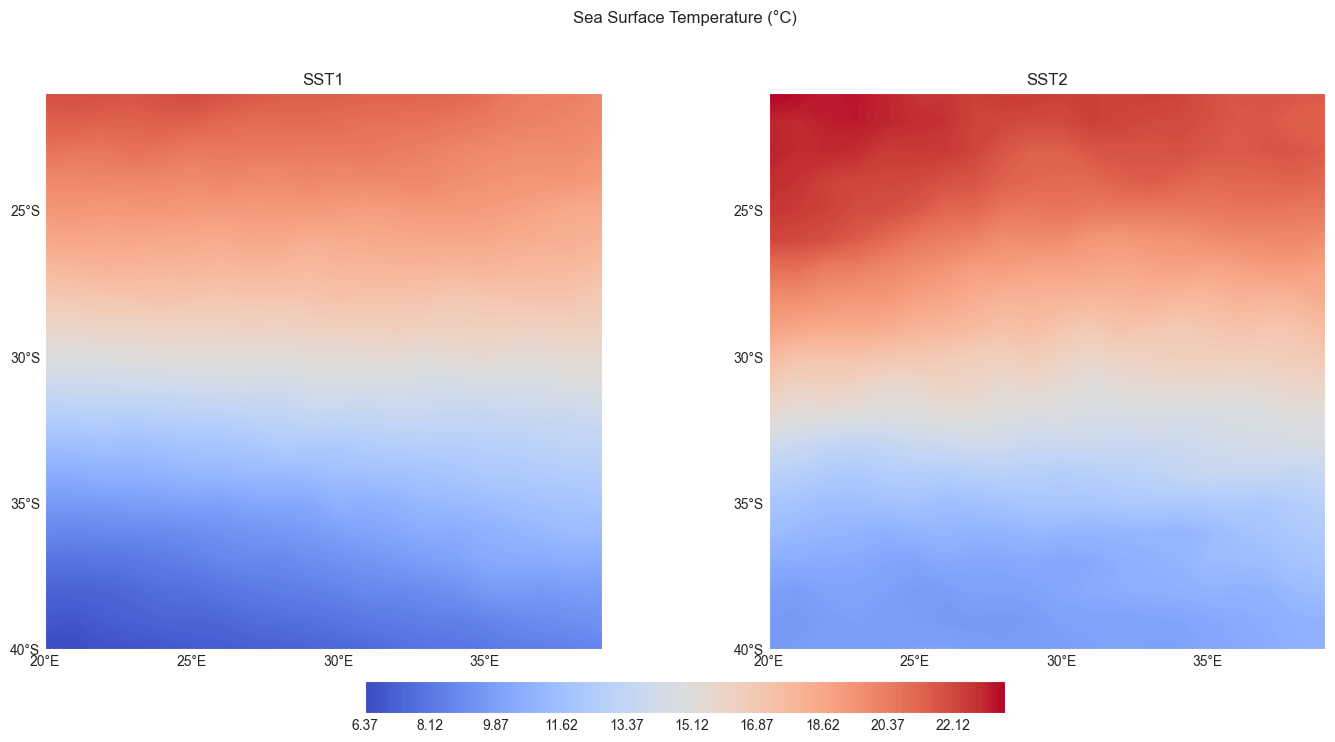

RMSE: 7.947328090667725


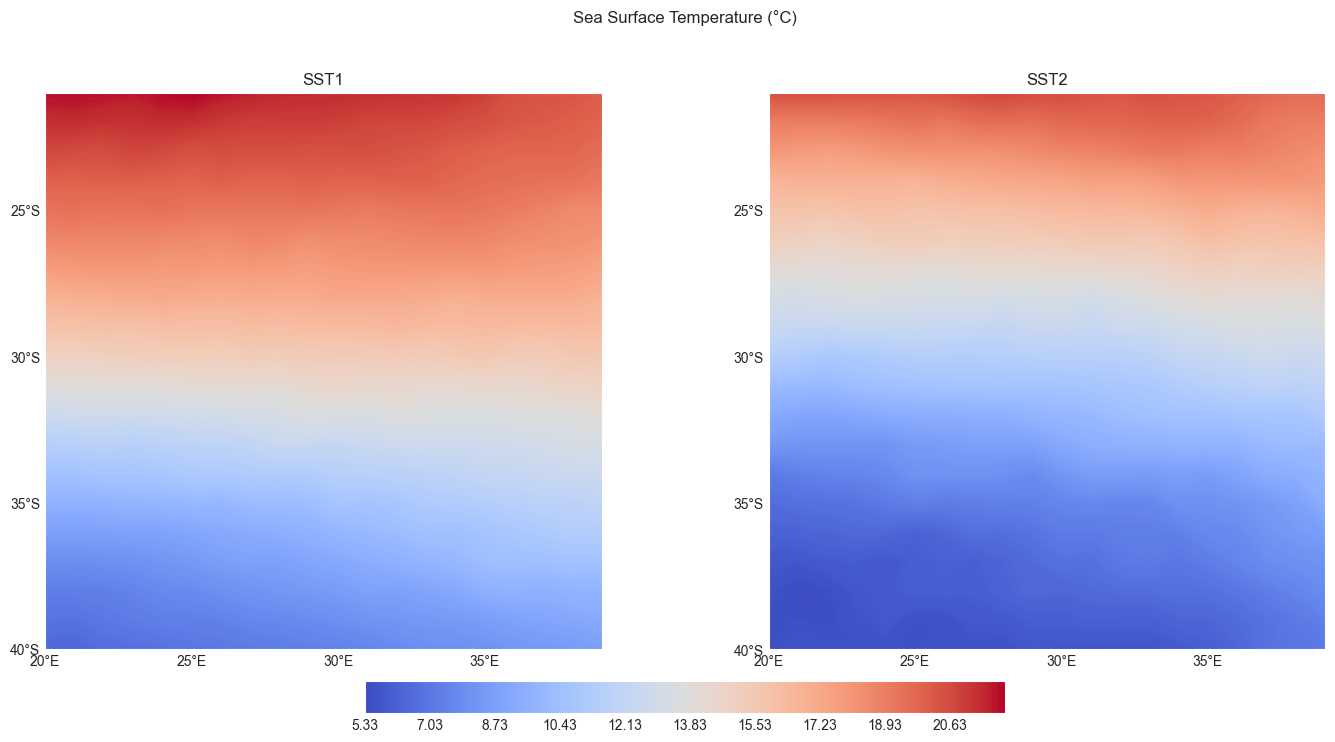

RMSE: 2.450676441192627


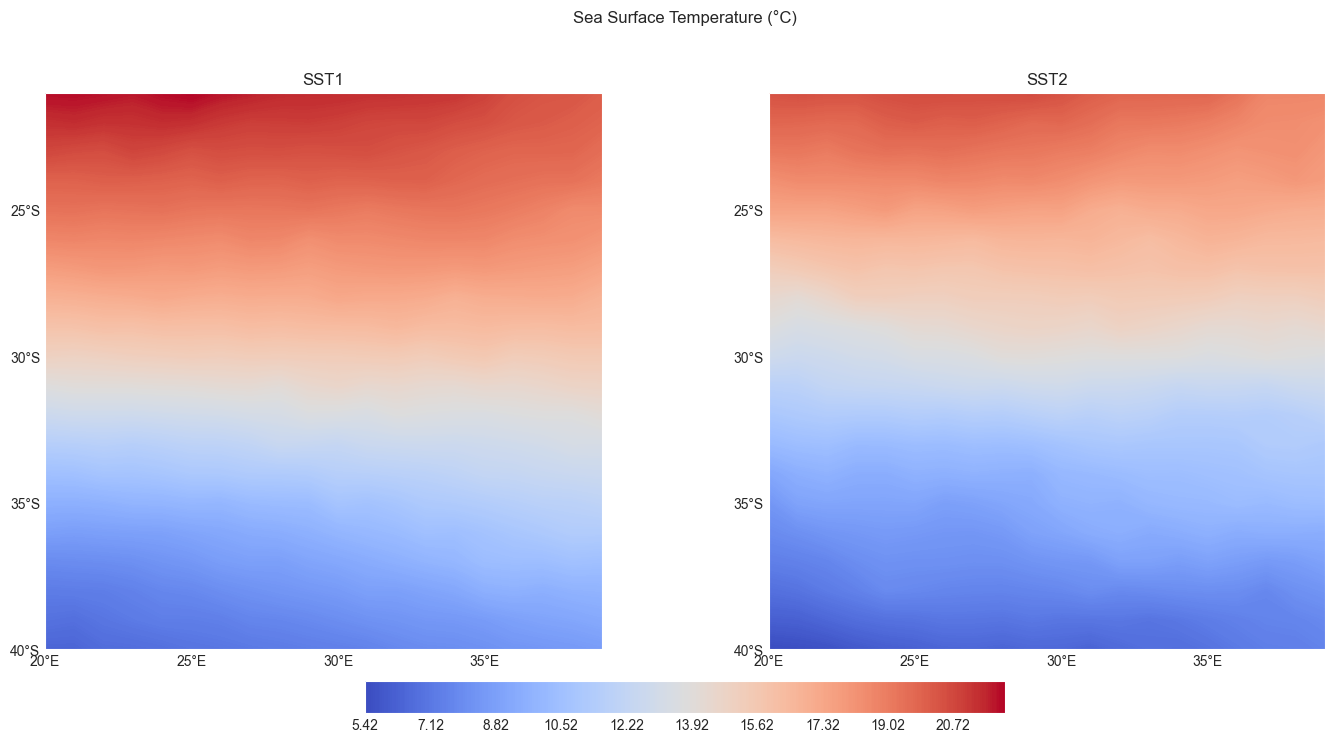

RMSE: 3.466585159301758


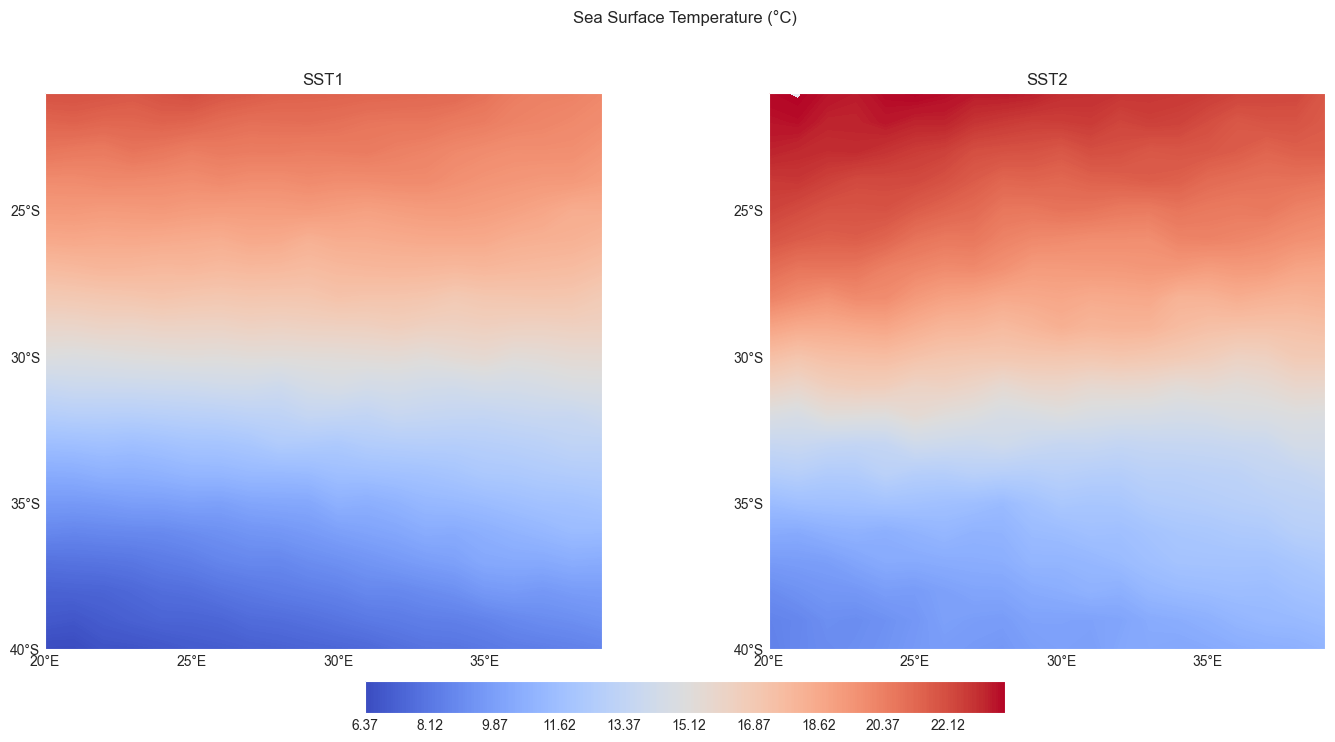

RMSE: 10.750566482543945


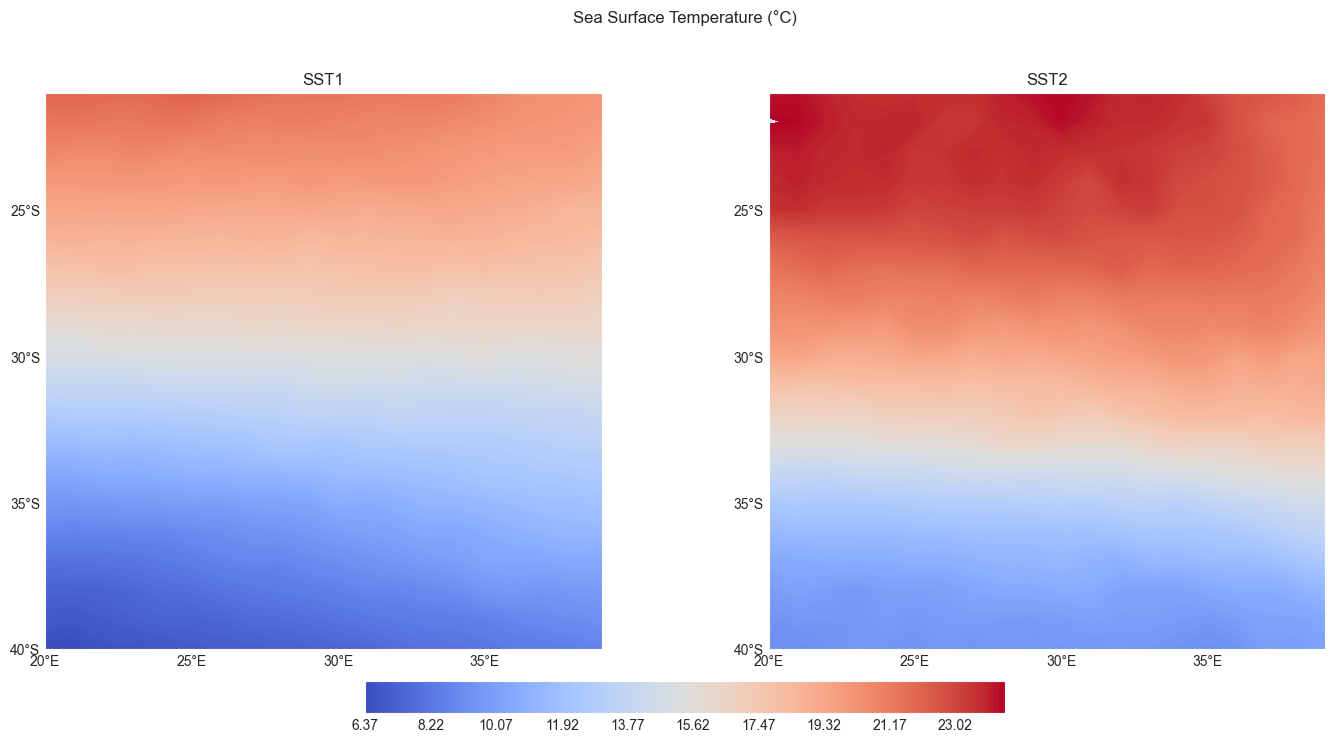

RMSE: 15.247729301452637


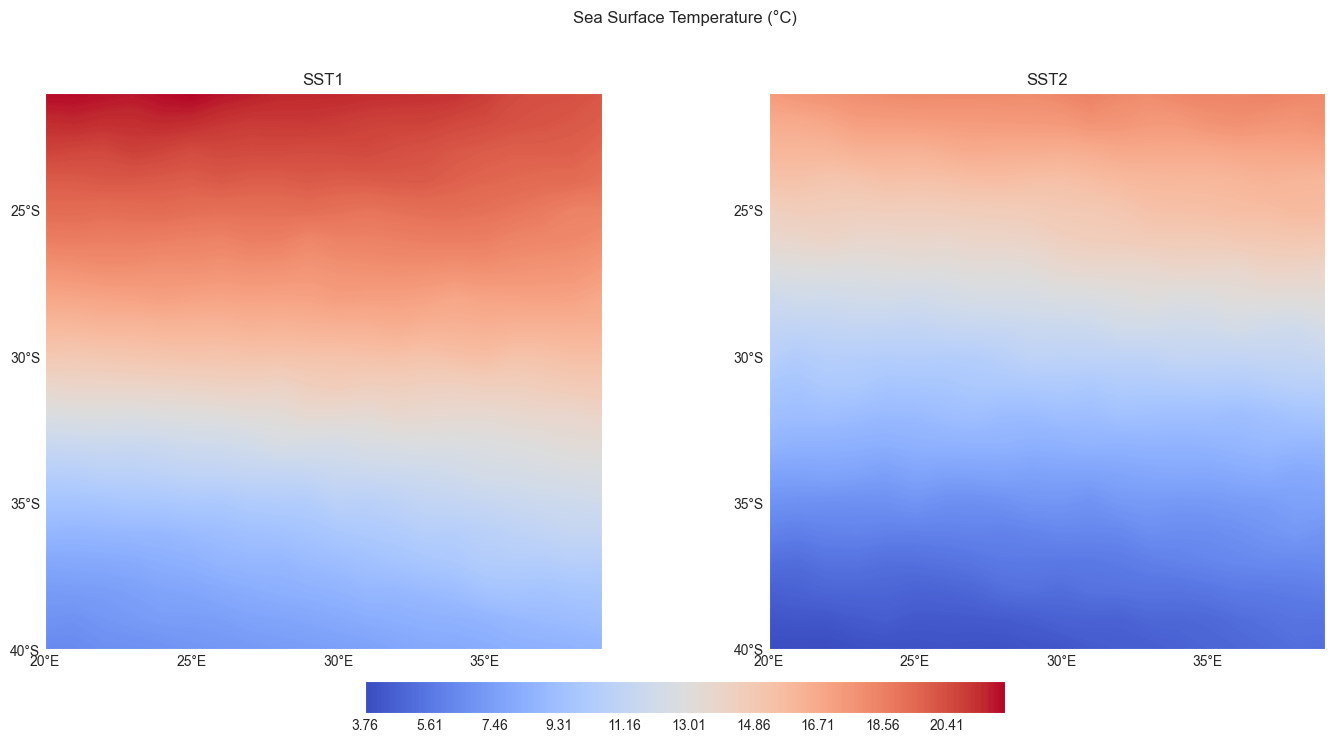

RMSE: 9.371387481689453


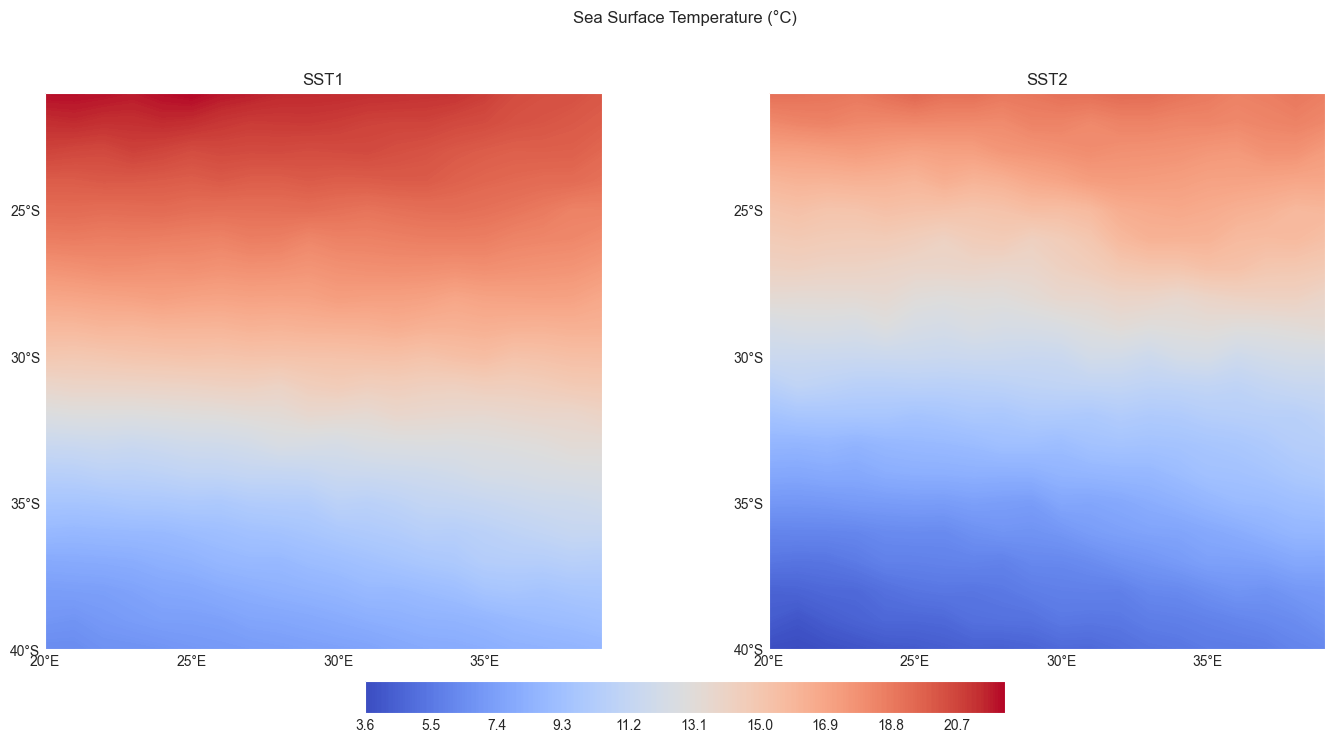

RMSE: 0.42650794982910156


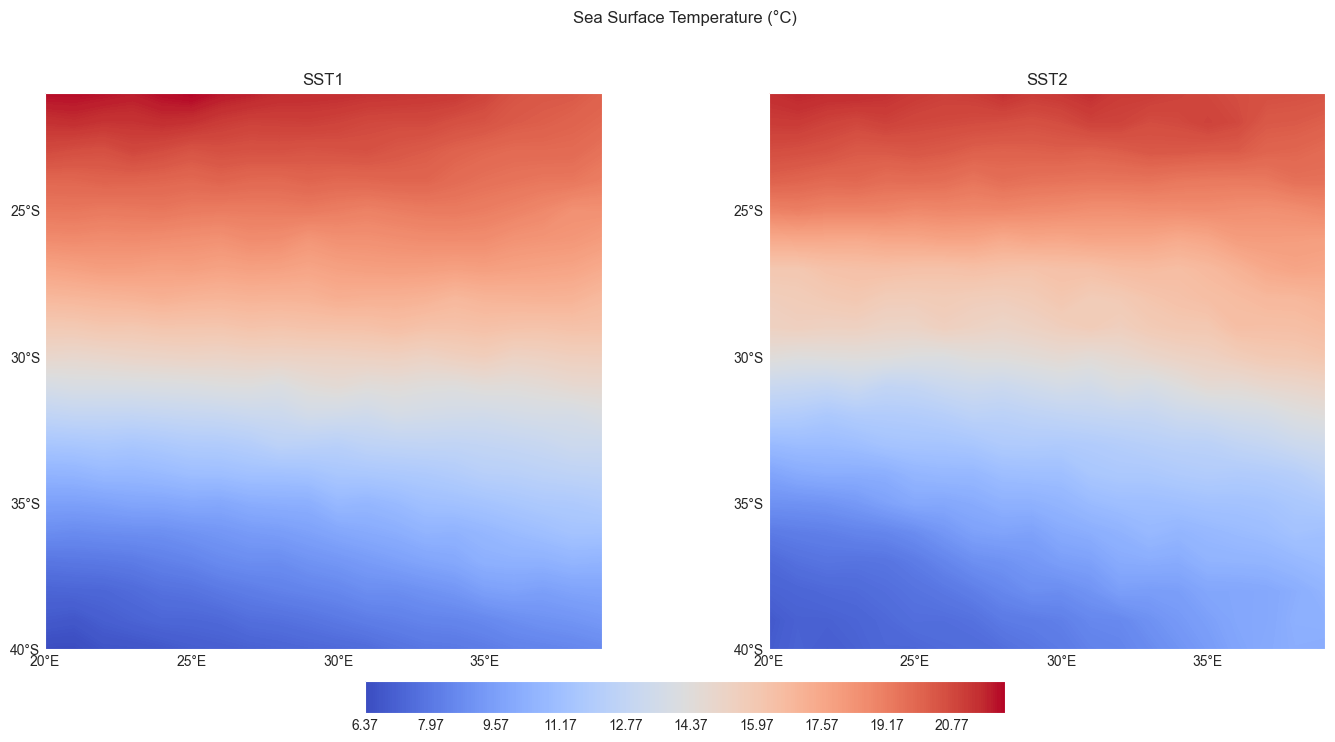

RMSE: 14.092779159545898


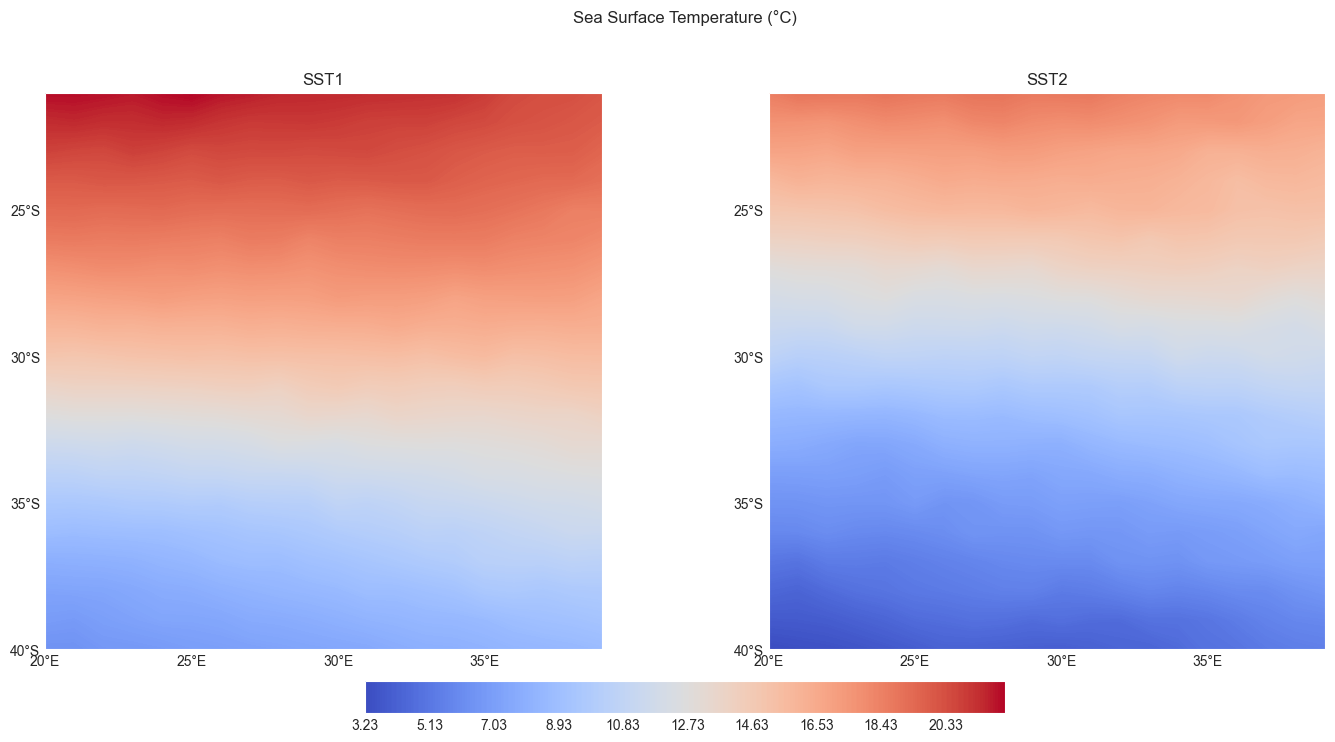

In [90]:
# 计算RMSE
from sklearn.metrics import mean_squared_error

for i in range(y_pred.shape[0]):
    y = y_pred[i, 0, :, :]
    g = y_test[i, 0, :, :]

    rmse = mean_squared_error(y.detach().numpy(), g.detach().numpy())
    print(f"RMSE: {rmse}")
    plot_sst_distribution_compare(y.detach().numpy(), g.detach().numpy())